In [3]:
import numpy as np

In [ ]:
a = np.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/TVT/data/ilsvrc_2012_mean.npy")

In [ ]:
a

In [ ]:
means = a.mean(axis=(1,2))/255.0

In [ ]:
print(means)

In [ ]:
stds = (a/255.0).std(axis=(1,2))
print(stds)

In [1]:
from data_utils import get_data
import numpy as np

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class_names,d99_dataloaders,_ = get_data("d99", batch_size=128)

35


In [3]:
# iter_d99 = iter(d99_dataloaders['train'])
# all_data = []
# for i in range(len(d99_dataloaders['train'])):
#     data,_ = iter_d99.next()
#     if i==0:
#         print(data.mean(dim=(0,2,3)))
#     all_data.append(data.mean(dim=(0,2,3)).numpy().reshape((1,3)))

# all_data = np.concatenate(all_data, axis=0)
# print(all_data.shape)
# print(all_data.mean(axis=0))
# print(data.var())


Mean of dataset99: [0.46083382 0.34022495 0.3280154 ]

In [5]:
print(data.var(dim=(0,2,3)))


tensor([0.0718, 0.0576, 0.0561])


In [3]:
class_names,cata_dataloaders,_ = get_data("cataracts")

# iter_cata = iter(cata_dataloaders['train'])
# all_data_cata = []
# for i in range(len(cata_dataloaders['train'])):
#     data,_ = iter_cata.next()
#     if i==0:
#         print(data.mean(dim=(0,2,3)))
#     all_data_cata.append(data.mean(dim=(0,2,3)).numpy().reshape((1,3)))

# all_data_cata = np.concatenate(all_data_cata, axis=0)
# print(all_data_cata.shape)
# print(all_data_cata.mean(axis=0))
# print(data.var(axis=(0,2,3)))


1240


means of cataracts dataset: 0.5726915  0.35134485 0.20473212

Visualization and testing for the saved models

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from utils import *
from data_utils import get_data
from transform_utils import *
from transformers_dann import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:

#helper functon for testing
def test(model, dataloader, len_classnames, use_dict=False):
    my_net = model
    my_net = my_net.eval()
    my_net = my_net.to(device)

    my_net = my_net.to(device)
    print("number of classes: ", len_classnames)
    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0
    total_preds = []
    total_labels = []

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        t_img = t_img.to(device)
        t_label = t_label.to(device)

        class_output = my_net(input_data=t_img, alpha=0, mode='test')
        pred = class_output.data.max(1, keepdim=True)[1]

        valid_pred, valid_label = pred, t_label
            
        n_correct += valid_pred.eq(valid_label.data.view_as(valid_pred)).cpu().sum()
        total_preds = total_preds + list(valid_pred.data.cpu().numpy().astype(int).reshape((-1,)))
        total_labels = total_labels + list(valid_label.data.cpu().numpy().astype(int).reshape((-1,)))
        # print(valid_label.size(dim=0))
        n_total += int(valid_label.size(dim=0))

        i += 1

    # print(valid_pred)
    
    accu = n_correct.data.numpy() * 1.0 / n_total
    acc,aacc = visda_acc(total_preds,total_labels)
    # micro_acc = micro_accuracy(total_preds, total_labels)
    print("n_total: ", n_total)
    # print("micro accuracy: ", micro_acc)
    print("visda accuracy: ", acc)
    print("classwise accuracy: ", aacc)
    print(accu)
    cr = (classification_report(total_labels, total_preds))
    print(cr)
    # return my_net


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [7]:
def load_model(model_path, class_names, use_vit=True):
    len_classnames = len(class_names)
    my_net = BARLOW_DANN(len_classnames,lambd=3.9e-3, scale_factor=0.1, use_vit=use_vit)
    my_net.load_state_dict(torch.load(model_path))
    my_net = my_net.eval()
    return my_net

In [8]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    model = model.to(device)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs, alpha=0, mode='test')
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [7]:
class_names, test_data, _ = get_data('d99')

139


In [10]:
class_names

['01',
 '02',
 '03',
 '04',
 '05',
 '07',
 '08',
 '09',
 '11',
 '13',
 '14',
 '16',
 '22',
 '25']

In [19]:
model_path = "//home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=False)

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
test(model, cata_dataloaders['test'], len(class_names))

number of classes:  14
n_total:  45938
visda accuracy:  32.131413515734835
classwise accuracy:  3.62 41.2 87.82 22.66 49.34 19.04 42.14 8.38 67.17 0.39 72.73 8.8 4.92 21.63
0.16689886368583742
              precision    recall  f1-score   support

           0       0.01      0.04      0.02       414
           1       0.22      0.41      0.29       665
           2       0.04      0.88      0.08       542
           3       0.31      0.23      0.26       578
           4       0.07      0.49      0.13       681
           5       0.17      0.19      0.18      3504
           6       0.08      0.42      0.13      1234
           7       0.34      0.08      0.13     11735
           8       0.20      0.67      0.31      1182
           9       0.03      0.00      0.01       257
          10       0.03      0.73      0.06        11
          11       0.03      0.09      0.04       125
          12       0.29      0.05      0.08     11718
          13       0.46      0.22      0.29     13

In [22]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-4_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, cata_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  45938
visda accuracy:  35.2109460383039
classwise accuracy:  17.87 21.95 73.8 40.48 50.81 54.88 41.41 4.62 68.78 0.0 54.55 36.8 2.24 24.76
0.18707823588314684
              precision    recall  f1-score   support

           0       0.18      0.18      0.18       414
           1       0.25      0.22      0.23       665
           2       0.04      0.74      0.08       542
           3       0.25      0.40      0.31       578
           4       0.04      0.51      0.07       681
           5       0.41      0.55      0.47      3504
           6       0.07      0.41      0.13      1234
           7       0.46      0.05      0.08     11735
           8       0.25      0.69      0.37      1182
           9       0.00      0.00      0.00       257
          10       0.01      0.55      0.03        11
          11       0.04      0.37      0.07       125
          12       0.30      0.02      0.04     11718
          13       0.44      0.25      0.32     132

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-2_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, cata_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  45938
visda accuracy:  35.0899961585351
classwise accuracy:  5.31 32.03 81.55 36.51 61.38 20.55 28.36 9.19 76.57 2.72 81.82 29.6 3.67 22.0
0.16907571074056338
              precision    recall  f1-score   support

           0       0.04      0.05      0.05       414
           1       0.20      0.32      0.25       665
           2       0.04      0.82      0.08       542
           3       0.37      0.37      0.37       578
           4       0.04      0.61      0.08       681
           5       0.33      0.21      0.25      3504
           6       0.07      0.28      0.11      1234
           7       0.35      0.09      0.15     11735
           8       0.25      0.77      0.37      1182
           9       0.15      0.03      0.05       257
          10       0.02      0.82      0.03        11
          11       0.07      0.30      0.11       125
          12       0.22      0.04      0.06     11718
          13       0.44      0.22      0.29     132

In [28]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss6_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  45938
visda accuracy:  32.58823340276572
classwise accuracy:  4.59 58.2 57.2 21.8 63.14 47.26 23.99 1.72 66.67 0.39 63.64 25.6 3.95 18.1
0.15505681570812835
              precision    recall  f1-score   support

           0       0.11      0.05      0.07       414
           1       0.14      0.58      0.23       665
           2       0.04      0.57      0.07       542
           3       0.32      0.22      0.26       578
           4       0.04      0.63      0.08       681
           5       0.26      0.47      0.33      3504
           6       0.07      0.24      0.11      1234
           7       0.29      0.02      0.03     11735
           8       0.19      0.67      0.30      1182
           9       0.06      0.00      0.01       257
          10       0.02      0.64      0.04        11
          11       0.08      0.26      0.12       125
          12       0.34      0.04      0.07     1

In [33]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss1_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  2057
visda accuracy:  12.878313314949258
classwise accuracy:  32.97 0.0 21.0 16.88 11.61 53.5 1.0 1.0 39.5 0.83 0.0 0.0 0.0 2.0
0.15119105493437043
              precision    recall  f1-score   support

           0       0.24      0.33      0.28        91
           1       0.00      0.00      0.00       115
           2       0.31      0.21      0.25       200
           3       0.32      0.17      0.22       154
           4       0.29      0.12      0.17       155
           5       0.19      0.54      0.28       200
           6       0.15      0.01      0.02       200
           7       0.02      0.01      0.01       200
           8       0.59      0.40      0.47       200
           9       0.01      0.01      0.01       120
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00        18
          12       0.00      0.00      0.00       200
    

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss5_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  45938
visda accuracy:  29.852082314722793
classwise accuracy:  6.28 36.99 51.11 28.2 42.44 37.61 39.87 0.26 70.73 0.0 54.55 16.8 1.61 31.49
0.17584570508076103
              precision    recall  f1-score   support

           0       0.59      0.06      0.11       414
           1       0.13      0.37      0.19       665
           2       0.04      0.51      0.08       542
           3       0.30      0.28      0.29       578
           4       0.05      0.42      0.09       681
           5       0.40      0.38      0.39      3504
           6       0.05      0.40      0.09      1234
           7       0.18      0.00      0.01     11735
           8       0.15      0.71      0.25      1182
           9       0.00      0.00      0.00       257
          10       0.06      0.55      0.11        11
          11       0.13      0.17      0.15       125
          12       0.25      0.02      0.03   

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  45938
visda accuracy:  30.016637998440164
classwise accuracy:  6.52 44.66 31.37 19.38 54.19 42.67 49.92 1.16 73.52 0.39 54.55 33.6 0.92 7.4
0.11389263790326092
              precision    recall  f1-score   support

           0       0.26      0.07      0.10       414
           1       0.21      0.45      0.29       665
           2       0.02      0.31      0.04       542
           3       0.39      0.19      0.26       578
           4       0.06      0.54      0.11       681
           5       0.28      0.43      0.34      3504
           6       0.04      0.50      0.07      1234
           7       0.19      0.01      0.02     11735
           8       0.20      0.74      0.32      1182
           9       0.17      0.00      0.01       257
          10       0.03      0.55      0.05        11
          11       0.19      0.34      0.24       125
          12       0.18      0.01      0.02   

In [9]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss8_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, cata_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  45938
visda accuracy:  29.091718951534943
classwise accuracy:  7.25 16.39 78.97 30.62 56.39 14.61 45.22 8.36 70.64 1.56 45.45 16.8 0.71 14.32
0.1312638773999739
              precision    recall  f1-score   support

           0       0.02      0.07      0.03       414
           1       0.18      0.16      0.17       665
           2       0.05      0.79      0.10       542
           3       0.19      0.31      0.23       578
           4       0.04      0.56      0.08       681
           5       0.16      0.15      0.15      3504
           6       0.07      0.45      0.12      1234
           7       0.35      0.08      0.13     11735
           8       0.17      0.71      0.27      1182
           9       0.08      0.02      0.03       257
          10       0.01      0.45      0.01        11
          11       0.02      0.17      0.03       125
          12       0.18      0.01      0.01     11718
          13       0.43      0.14      0.21     1

In [35]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss6_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, cata_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  45938
visda accuracy:  31.511421008967975
classwise accuracy:  10.87 45.11 74.91 15.57 23.35 24.83 34.12 2.76 60.32 1.17 90.91 31.2 2.04 24.01
0.14824328442683618
              precision    recall  f1-score   support

           0       0.06      0.11      0.08       414
           1       0.11      0.45      0.18       665
           2       0.04      0.75      0.08       542
           3       0.20      0.16      0.17       578
           4       0.04      0.23      0.07       681
           5       0.18      0.25      0.21      3504
           6       0.05      0.34      0.08      1234
           7       0.29      0.03      0.05     11735
           8       0.20      0.60      0.30      1182
           9       0.01      0.01      0.01       257
          10       0.01      0.91      0.03        11
          11       0.04      0.31      0.07       125
          12       0.35      0.02      0.04     11718
          13       0.40      0.24      0.30    

Test for D99 test set

In [39]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_only_train_timm_bs16_bm1e-3_loss4_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  14.768703993602376
classwise accuracy:  1.78 10.82 0.63 19.37 60.0 4.93 10.32 58.55 18.45 0.0 0.0 0.0 0.0 21.91
0.17843188330294346
              precision    recall  f1-score   support

           0       0.04      0.02      0.03       169
           1       0.06      0.11      0.07       194
           2       0.25      0.01      0.01       319
           3       0.36      0.19      0.25       315
           4       0.38      0.60      0.46       370
           5       0.43      0.05      0.09       304
           6       0.13      0.10      0.11       339
           7       0.15      0.59      0.24       345
           8       0.42      0.18      0.26       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.00      0.00      0.00       30

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_timm_bs16_bm1e-3_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  17.350430614613575
classwise accuracy:  0.0 1.03 0.94 27.94 72.7 16.12 24.48 22.03 15.77 0.0 0.0 0.0 5.0 56.89
0.20812711643657203
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.01      0.01      0.01       194
           2       0.18      0.01      0.02       319
           3       0.52      0.28      0.36       315
           4       0.19      0.73      0.30       370
           5       0.54      0.16      0.25       304
           6       0.27      0.24      0.26       339
           7       0.13      0.22      0.16       345
           8       0.49      0.16      0.24       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.06      0.05      0.06       300

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_timm_bs16_bm1e-3_loss6_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  16.423525521877405
classwise accuracy:  6.51 5.15 8.78 25.71 49.73 3.29 39.23 58.84 27.38 0.0 0.0 0.0 0.0 5.3
0.19979161239906226
              precision    recall  f1-score   support

           0       0.13      0.07      0.09       169
           1       0.04      0.05      0.04       194
           2       0.25      0.09      0.13       319
           3       0.33      0.26      0.29       315
           4       0.40      0.50      0.44       370
           5       0.53      0.03      0.06       304
           6       0.21      0.39      0.27       339
           7       0.19      0.59      0.29       345
           8       0.58      0.27      0.37       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.00      0.00      0.00       300


/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_timm_bs16_bm1e-3_loss5_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  15.382910878879756
classwise accuracy:  0.0 0.0 0.94 36.19 63.51 9.54 34.51 17.68 1.79 0.0 0.0 0.0 0.67 50.53
0.184943995832248
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.00      0.00      0.00       194
           2       0.75      0.01      0.02       319
           3       0.55      0.36      0.44       315
           4       0.19      0.64      0.29       370
           5       0.33      0.10      0.15       304
           6       0.26      0.35      0.30       339
           7       0.11      0.18      0.13       345
           8       0.40      0.02      0.03       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.05      0.01      0.01       300
  

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_timm_bs16_bm1e-3_loss4_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  18.376527404614844
classwise accuracy:  0.0 5.15 11.6 30.79 63.24 14.14 13.57 30.14 21.13 0.0 0.0 0.0 0.0 67.49
0.21698358947642615
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.05      0.05      0.05       194
           2       0.29      0.12      0.17       319
           3       0.31      0.31      0.31       315
           4       0.23      0.63      0.34       370
           5       0.23      0.14      0.17       304
           6       0.30      0.14      0.19       339
           7       0.28      0.30      0.29       345
           8       0.36      0.21      0.27       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.00      0.00      0.00       30

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_timm_bs16_bm1e-3_loss8_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, d99_dataloaders['test'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  3839
visda accuracy:  17.35514383223715
classwise accuracy:  0.0 8.76 4.39 14.6 63.24 27.63 15.04 42.03 21.73 0.0 0.0 0.0 0.67 44.88
0.20656420942953893
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.06      0.09      0.07       194
           2       0.09      0.04      0.06       319
           3       0.47      0.15      0.22       315
           4       0.30      0.63      0.41       370
           5       0.44      0.28      0.34       304
           6       0.16      0.15      0.16       339
           7       0.17      0.42      0.24       345
           8       0.45      0.22      0.29       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.02      0.01      0.01       300

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_r50_bs16_bm1e-3_loss5_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, d99_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  3839
visda accuracy:  18.464014223350627
classwise accuracy:  1.18 2.58 0.31 47.62 43.24 30.26 15.63 56.81 31.25 0.0 0.0 0.0 19.0 10.6
0.2216723104975254
              precision    recall  f1-score   support

           0       0.02      0.01      0.01       169
           1       0.10      0.03      0.04       194
           2       0.01      0.00      0.00       319
           3       0.70      0.48      0.57       315
           4       0.54      0.43      0.48       370
           5       0.46      0.30      0.37       304
           6       0.19      0.16      0.17       339
           7       0.17      0.57      0.27       345
           8       0.35      0.31      0.33       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.14      0.19      0.16       300
          13       0.04      0.11      0.06       283

 

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_r50_bs16_bm1e-3_loss6_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, d99_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  3839
visda accuracy:  23.055501257570434
classwise accuracy:  1.78 8.25 0.63 40.63 48.38 40.79 20.65 33.91 30.06 0.0 0.0 0.0 50.0 47.7
0.26699661370148475
              precision    recall  f1-score   support

           0       0.03      0.02      0.02       169
           1       0.10      0.08      0.09       194
           2       0.13      0.01      0.01       319
           3       0.83      0.41      0.54       315
           4       0.68      0.48      0.56       370
           5       0.39      0.41      0.40       304
           6       0.17      0.21      0.18       339
           7       0.21      0.34      0.26       345
           8       0.37      0.30      0.33       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.23      0.50      0.32       300
          13       0.15      0.48      0.22       283



/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_r50_bs16_bm1e-3_loss7_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, d99_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  3839
visda accuracy:  23.29047980404449
classwise accuracy:  8.88 4.12 2.82 34.92 54.32 31.58 16.22 51.59 29.17 0.0 0.0 0.0 37.67 54.77
0.2703829122167231
              precision    recall  f1-score   support

           0       0.08      0.09      0.09       169
           1       0.04      0.04      0.04       194
           2       0.30      0.03      0.05       319
           3       0.95      0.35      0.51       315
           4       0.63      0.54      0.58       370
           5       0.55      0.32      0.40       304
           6       0.20      0.16      0.18       339
           7       0.17      0.52      0.26       345
           8       0.42      0.29      0.34       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.24      0.38      0.29       300
          13       0.19      0.55      0.29       283



/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_r50_bs16_bm1e-3_loss8_best.pth"
model = load_model(model_path,class_names,use_vit=False)
test(model, d99_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  3839
visda accuracy:  21.41037483169395
classwise accuracy:  4.73 6.19 1.88 47.62 22.97 28.29 12.09 55.65 28.57 0.0 0.0 0.0 8.0 83.75
0.2440739775983329
              precision    recall  f1-score   support

           0       0.06      0.05      0.05       169
           1       0.05      0.06      0.06       194
           2       0.40      0.02      0.04       319
           3       0.87      0.48      0.62       315
           4       0.65      0.23      0.34       370
           5       0.37      0.28      0.32       304
           6       0.23      0.12      0.16       339
           7       0.18      0.56      0.28       345
           8       0.35      0.29      0.32       336
           9       0.00      0.00      0.00       124
          10       0.00      0.00      0.00       228
          11       0.00      0.00      0.00       213
          12       0.07      0.08      0.07       300
          13       0.22      0.84      0.35       283

  

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_d99_tgt_cataracts_timm_bs16_bm1_loss5_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['val'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  1680
visda accuracy:  31.547619047619055
classwise accuracy:  3.33 69.17 20.83 26.67 92.5 6.67 47.5 1.67 74.17 0.0 92.5 2.5 1.67 2.5
0.31547619047619047
              precision    recall  f1-score   support

           0       0.80      0.03      0.06       120
           1       0.42      0.69      0.53       120
           2       0.14      0.21      0.16       120
           3       0.46      0.27      0.34       120
           4       0.44      0.93      0.60       120
           5       0.50      0.07      0.12       120
           6       0.14      0.47      0.21       120
           7       0.29      0.02      0.03       120
           8       0.47      0.74      0.57       120
           9       0.00      0.00      0.00       120
          10       0.70      0.93      0.80       120
          11       0.05      0.03      0.03       120
          12       0.02      0.02      0.02       120

In [33]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_d99_tgt_cataracts_timm_bs16_bm1_loss6_best.pth"
model = load_model(model_path,class_names,use_vit=True)
test(model, cata_dataloaders['val'], len(class_names))

Loaded Checkpoint of ViT vit_checkpoints/ViT-B_16-224.npz
number of classes:  14
n_total:  1680
visda accuracy:  34.404761904761905
classwise accuracy:  36.67 0.0 10.0 42.5 95.0 72.5 0.0 5.83 75.0 3.33 95.83 28.33 1.67 15.0
0.34404761904761905
              precision    recall  f1-score   support

           0       0.22      0.37      0.28       120
           1       0.00      0.00      0.00       120
           2       0.57      0.10      0.17       120
           3       0.38      0.42      0.40       120
           4       0.76      0.95      0.84       120
           5       0.27      0.72      0.39       120
           6       0.00      0.00      0.00       120
           7       0.12      0.06      0.08       120
           8       0.65      0.75      0.69       120
           9       0.08      0.03      0.05       120
          10       0.26      0.96      0.41       120
          11       0.38      0.28      0.32       120
          12       0.67      0.02      0.03       120

In [9]:
# from torchmetrics.classification import MulticlassAUROC
def test_model_mycode2(model, test_loader, verbose=True):
    

    model.eval()   # Set model to evaluate mode
    model = model.to(device)
    running_corrects = 0
    # metric = MulticlassAUROC(num_classes=14, average="macro", thresholds=None)
    count=0
    preds_all = []
    gold = []
    for inputs, labels in test_loader:
        count+=labels.shape[0]
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # print("AUROCmetric: ", metric(outputs, labels))
        preds_all.append(preds.cpu())
        gold.append(labels.data.cpu())
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_acc = running_corrects.double() / count

    gold = np.concatenate(gold)
    preds_all = np.concatenate(preds_all)

    if verbose:
        print(f'Best val Acc: {epoch_acc:4f}')
        matrix = confusion_matrix(gold, preds_all)
        print(matrix)
        classwise_acc = matrix.diagonal()/matrix.sum(axis=1)
        print(classwise_acc)
        FP = matrix.sum(axis=0) - np.diag(matrix)  
        FN = matrix.sum(axis=1) - np.diag(matrix)
        TP = np.diag(matrix)
        TN = matrix.sum() - (FP + FN + TP)
        print("TPR: ", (TP/(TP+FN)))
        print("FPR: ", (FP/(FP+TN)))
        # print("Macro Recall: ", balanced_accuracy_score(gold,preds_all))
    return preds_all, gold

    # load best model weights

In [6]:
model_r50 = models.resnet50(pretrained=True)
num_ftrs = model_r50.fc.in_features
model_r50.fc = nn.Linear(num_ftrs, len(class_names))

#only cataracts
# model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/model_r50_trained_on_final_cataracts_only_ep25-50.pth"))
#only d99
model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r50_trained_on_final_d99.pth"))

model_r50 = model_r50.to(device)

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# count=0
# len(cata_dataloaders['test'])
# for inputs, labels in cata_dataloaders['test']:
#     count+=labels.shape[0]
# print(count)


In [10]:
test_model_mycode2(model_r50,d99_dataloaders['test'])

AUROCmetric:  tensor(0.9166, device='cuda:0')
AUROCmetric:  tensor(0.9311, device='cuda:0')
AUROCmetric:  tensor(0.9367, device='cuda:0')


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 47.46 GiB total capacity; 32.35 GiB already allocated; 106.31 MiB free; 32.63 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [43]:
test_model_mycode2(model_r50,cata_dataloaders['test'])

KeyboardInterrupt: 

In [12]:
'''
01 - secondary incision knife - paracenthesis blade
02 - bonn forceps - 0.12 forceps
03 - charleux cannula - AC Cannula
04 - primary incision knife - keratome
05 - capsulorhexis forceps - utrata forceps
07 - capsulorhexis cystotome - cystotome
08 - hydrodissection cannula - hydrodissection cannula
09 - phacoemulsifier handpiece - phaco
11 - implant injector - IOL injector
13 - suture needle - suture
14 - cotton - eweckell sponge
16 - needle holder - needle driver
22 - irrigation - irrigation
25 - micromanipulator - chopper
'''

'\n01 - secondary incision knife - paracenthesis blade\n02 - bonn forceps - 0.12 forceps\n03 - charleux cannula - AC Cannula\n04 - primary incision knife - keratome\n05 - capsulorhexis forceps - utrata forceps\n07 - capsulorhexis cystotome - cystotome\n08 - hydrodissection cannula - hydrodissection cannula\n09 - phacoemulsifier handpiece - phaco\n11 - implant injector - IOL injector\n13 - suture needle - suture\n14 - cotton - eweckell sponge\n16 - needle holder - needle driver\n22 - irrigation - irrigation\n25 - micromanipulator - chopper\n'

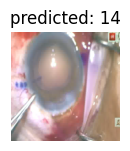

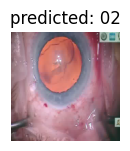

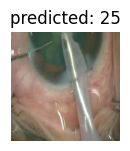

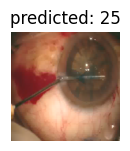

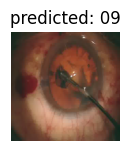

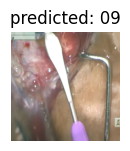

In [13]:
visualize_model(model, test_data, class_names)

In [66]:
#data stuff
data_dir = "/home/ubuntu/Desktop/Domain_Adaptation_Project/data/final_cataracts"
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5726915, 0.35134485, 0.20473212], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5726915, 0.35134485, 0.20473212], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5726915, 0.35134485, 0.20473212], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
                for x in ['train','val','test']
}


In [67]:
data_dir99_balanced = "/home/ubuntu/Desktop/Domain_Adaptation_Project/data/final_d99"
train_dir99_bal = os.path.join(data_dir99_balanced, 'train')
# val_dir99_bal = os.path.join(data_dir99_balanced, 'train')
val_dir99_bal = os.path.join(data_dir99_balanced, 'val')
test_dir99_bal = os.path.join(data_dir99_balanced, 'test')

data_transforms99 = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.46083382, 0.34022495, 0.3280154], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.46083382, 0.34022495, 0.3280154], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.46083382, 0.34022495, 0.3280154], [0.229, 0.224, 0.225])
    ]),
}
image_datasets99_balanced = {x: datasets.ImageFolder(os.path.join(data_dir99_balanced,x),data_transforms99[x]) for x in ['val','train','test']}

dataloaders99_balanced = {x: torch.utils.data.DataLoader(image_datasets99_balanced[x], batch_size=32, shuffle=True, num_workers=4)
                for x in ['train','val','test']
}


In [46]:
from sklearn.manifold import TSNE

In [92]:
# model_path = '/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_d99_tgt_cataracts_r50_bs16_bm1e-3_loss7_best.pth'
model_path = '/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_cataracts_tgt_d99_r50_bs16_bm1e-3_loss7_best.pth'

model = load_model(model_path,class_names, use_vit=False)

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
l5_model_path = '/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models/src_d99_tgt_cataracts_r50_bs16_bm1_loss5_best.pth'
l5_model = load_model(model_path, class_names, use_vit=False)

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
so_model_path = '/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r18_trained_on_d99.pth'
so_model_path = '/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r18_trained_on_final_cataracts_only.pth'

model_r18 = models.resnet18(pretrained=False)
num_ftrs = model_r18.fc.in_features
model_r18.fc = nn.Identity()
model_r18.load_state_dict(torch.load(so_model_path),strict=False)
so_model = model_r18

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [48]:
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 


In [87]:
def show_tsne(model, data_additional=False):
    d99_class_names, d99_test_data, _ = get_data('d99')
    cataracts_class_names, cataracts_test_data, _ = get_data('cataracts')

    if data_additional:
        cataracts_test_data = dataloaders
        d99_test_data = dataloaders99_balanced
    d99_features = []
    cataracts_features = []

    model =model.to(device)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(d99_test_data['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            try:
                outputs = model.feature(inputs)
            except:
                outputs = model(inputs)
            d99_features.append(outputs.cpu().numpy())
            # all_labels.append(labels.cpu().numpy())

        for i, (inputs, labels) in enumerate(cataracts_test_data['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            try:
                outputs = model.feature(inputs)
            except:
                outputs = model(inputs)

            cataracts_features.append(outputs.cpu().numpy())
            # all_labels.append(labels.cpu().numpy())

    # print(d99_features[0].shape)
    d99_features = np.concatenate(d99_features, axis=0)
    cataracts_features = np.concatenate(cataracts_features, axis=0)

    cataracts_tsne = TSNE().fit_transform(cataracts_features)
    d99_tsne = TSNE().fit_transform(d99_features)

    # extract x and y coordinates representing the positions of the images on T-SNE plot
    d99_tx = d99_tsne[:, 0]
    d99_ty = d99_tsne[:, 1]
    
    d99_tx = scale_to_01_range(d99_tx)
    d99_ty = scale_to_01_range(d99_ty)

    # extract x and y coordinates representing the positions of the images on T-SNE plot
    cataracts_tx = cataracts_tsne[:, 0]
    cataracts_ty = cataracts_tsne[:, 1]
    
    cataracts_tx = scale_to_01_range(cataracts_tx)
    cataracts_ty = scale_to_01_range(cataracts_ty)
    
    # initialize a matplotlib plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # for every class, we'll add a scatter plot separately
    # find the samples of the current class in the data

    # extract the coordinates of the points of this class only
    # convert the class color to matplotlib format
    # color = np.array(colors_per_class[label], dtype=np.float) / 255

    # add a scatter plot with the corresponding color and label
    ax.scatter(d99_tx, d99_ty, label="d99")
    ax.scatter(cataracts_tx, cataracts_ty, label="cataracts")
    
    # build a legend using the labels we set previously
    ax.legend(loc='best')
    
    # finally, show the plot
    plt.show()

139
245


/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


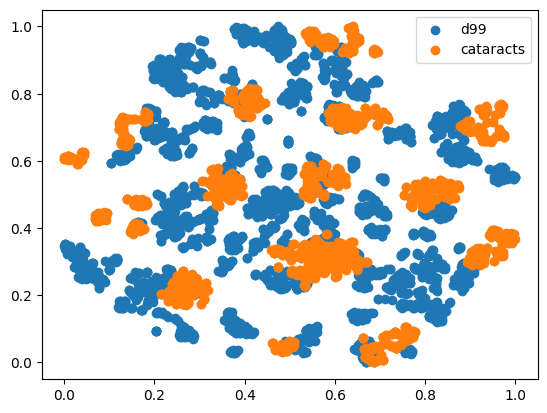

In [94]:
show_tsne(model)

139
245


/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


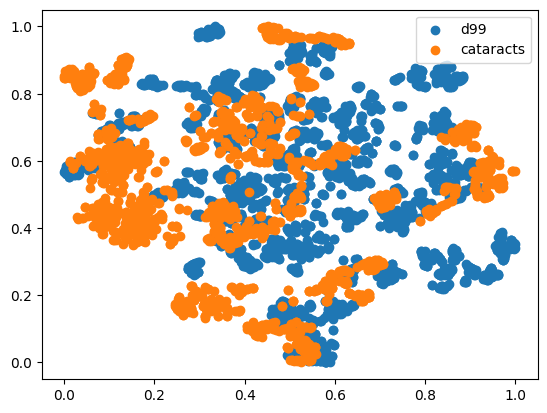

In [54]:
#loss 5
show_tsne(l5_model)

139
245


/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


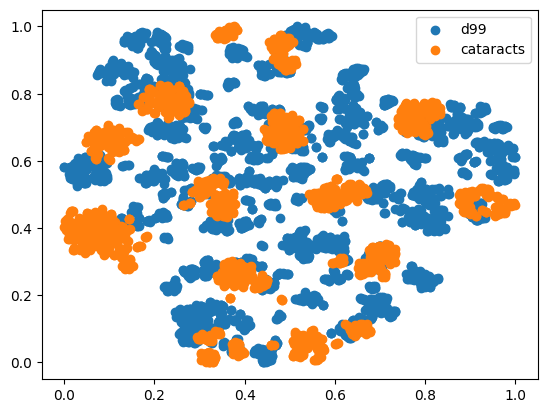

: 

In [95]:
show_tsne(so_model, True)

In [10]:
from data_utils import get_data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from utils import *
from data_utils import get_data
from transform_utils import *
from transformers_dann import *
import sys
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# mode = int(sys.argv[1])

class_names,d99_dataloaders,_ = get_data("d99", batch_size=128)
class_names,cata_dataloaders,_ = get_data("cataracts")


from torchmetrics.classification import MulticlassAUROC, MulticlassROC

import pdb

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class CNNModel(nn.Module):

    def __init__(self, class_names_len, pretrained_weights=''):
        super(CNNModel, self).__init__()
        if pretrained_weights!='':
            self.feature = models.resnet50(pretrained=False)
            self.feature.load_state_dict(torch.load(pretrained_weights),strict=False)
        else:
            # self.feature = models.resnet18(pretrained=True)
            self.feature = models.resnet50(pretrained=True)

        self.in_features = self.feature.fc.in_features
        self.feature.fc = nn.Identity()
        # self.feature = nn.Sequential()
        # self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        # self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        # self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        # self.feature.add_module('f_relu1', nn.ReLU(True))
        # self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        # self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        # self.feature.add_module('f_drop1', nn.Dropout2d())
        # self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        # self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(self.in_features, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, class_names_len))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(self.in_features, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        # input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, self.in_features)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

#helper functon for testing
def test(model, dataloader, len_classnames, use_dict=False):
    with torch.no_grad():
        my_net = model
        my_net = my_net.eval()
        metric = MulticlassAUROC(num_classes=14, average="macro", thresholds=None)
        metric_wt = MulticlassAUROC(num_classes=14, average="weighted", thresholds=None)
        metric_none = MulticlassAUROC(num_classes=14, average="none", thresholds=None)
        metric_roc = MulticlassROC(num_classes=14, thresholds=None)

        my_net = my_net.to(device)

        my_net = my_net.to(device)
        print("number of classes: ", len_classnames)
        len_dataloader = len(dataloader)
        data_target_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_preds = []
        total_labels = []
        outputs_all = []


        while i < len_dataloader:

            # test model using target data
            data_target = data_target_iter.next()
            t_img, t_label = data_target

            t_img = t_img.to(device)
            t_label = t_label.to(device)

            class_output = my_net(input_data=t_img, alpha=0, mode='test')
            pred = class_output.data.max(1, keepdim=True)[1]
            outputs_all.append(class_output.cpu())


            valid_pred, valid_label = pred, t_label
                
            n_correct += valid_pred.eq(valid_label.data.view_as(valid_pred)).cpu().sum()
            total_preds = total_preds + list(valid_pred.data.cpu().numpy().astype(int).reshape((-1,)))
            total_labels = total_labels + list(valid_label.data.cpu().numpy().astype(int).reshape((-1,)))
            # print(valid_label.size(dim=0))
            n_total += int(valid_label.size(dim=0))

            i += 1

        # print(valid_pred)
        
        accu = n_correct.data.numpy() * 1.0 / n_total
        acc,aacc = visda_acc(total_preds,total_labels)
        # micro_acc = micro_accuracy(total_preds, total_labels)
        print("n_total: ", n_total)
        # print("micro accuracy: ", micro_acc)
        print("visda accuracy: ", acc)
        print("classwise accuracy: ", aacc)
        print(accu)
        cr = (classification_report(total_labels, total_preds))
        print(cr)

        outputs_all = torch.cat(outputs_all,dim=0)
        print("roc auc score: ", metric((outputs_all), torch.tensor(total_labels)))
        print("roc auc score weighted: ", metric_wt((outputs_all), torch.tensor(total_labels)))
        print("roc auc score none: ", metric_none((outputs_all), torch.tensor(total_labels)))

        fpr, tpr, thresholds = metric_roc(outputs_all, torch.tensor(total_labels))
        # plt.plot(fpr[0],tpr[0])

        return fpr, tpr
        # return my_net

def load_model(model_path, class_names, use_vit=True):
    len_classnames = len(class_names)
    my_net = BARLOW_DANN(len_classnames,lambd=3.9e-3, scale_factor=0.1, use_vit=use_vit)
    my_net.load_state_dict(torch.load(model_path))
    my_net = my_net.eval()
    return my_net

def test_model_mycode2(model, test_loader, verbose=True):
    
    with torch.no_grad():
        model.eval()   # Set model to evaluate mode
        model = model.to(device)
        running_corrects = 0
        metric = MulticlassAUROC(num_classes=14, average="macro", thresholds=None)
        metric_wt = MulticlassAUROC(num_classes=14, average="weighted", thresholds=None)
        metric_none = MulticlassAUROC(num_classes=14, average="none", thresholds=None)
        metric_roc = MulticlassROC(num_classes=14, thresholds=None)

        count=0
        preds_all = []
        outputs_all = []
        gold = []
        for inputs, labels in test_loader:
            count+=labels.shape[0]
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # pdb.set_trace()
            # print("AUROCmetric: ", metric(outputs, labels))
            preds_all.append(preds.cpu())
            outputs_all.append(outputs.cpu())
            gold.append(labels.data.cpu())
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_acc = running_corrects.double() / count

        gold = np.concatenate(gold)
        preds_all = np.concatenate(preds_all)
        outputs_all = np.concatenate(outputs_all)

        if verbose:
            print(f'Best val Acc: {epoch_acc:4f}')
            matrix = confusion_matrix(gold, preds_all)
            print(matrix)
            classwise_acc = matrix.diagonal()/matrix.sum(axis=1)
            print(classwise_acc)
            FP = matrix.sum(axis=0) - np.diag(matrix)  
            FN = matrix.sum(axis=1) - np.diag(matrix)
            TP = np.diag(matrix)
            TN = matrix.sum() - (FP + FN + TP)
            print("TPR: ", (TP/(TP+FN)))
            print("FPR: ", (FP/(FP+TN)))
            print("roc auc score: ", metric(torch.tensor(outputs_all), torch.tensor(gold)))
            print("roc auc score wt: ", metric_wt(torch.tensor(outputs_all), torch.tensor(gold)))
            print("roc auc score none: ", metric_none(torch.tensor(outputs_all), torch.tensor(gold)))
            # print("Macro Recall: ", balanced_accuracy_score(gold,preds_all))
        
        fpr, tpr, thresholds = metric_roc(torch.tensor(outputs_all), torch.tensor(gold))
        
    return fpr, tpr

    # load best model weights

def test_DANN(model_path, dataloader, len_classnames, use_dict=False):
    with torch.no_grad():
        my_net = CNNModel(len_classnames)
        my_net.load_state_dict(torch.load(model_path))
        my_net = my_net.eval()

        my_net = my_net.to(device)

        len_dataloader = len(dataloader)
        data_target_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        preds_all = []
        outputs_all = []
        gold = []

        while i < len_dataloader:

            # test model using target data
            data_target = data_target_iter.next()
            t_img, t_label = data_target

            batch_size = len(t_label)

            t_img = t_img.to(device)
            t_label = t_label.to(device)

            class_output, _ = my_net(input_data=t_img, alpha=0)
            pred = class_output.data.max(1, keepdim=True)[1]

            preds_all.append(pred.cpu())
            outputs_all.append(class_output.cpu())
            gold.append(t_label.data.cpu())

            i += 1

        gold = np.concatenate(gold)
        preds_all = np.concatenate(preds_all)
        outputs_all = np.concatenate(outputs_all)

        matrix = confusion_matrix(gold, preds_all)
        print(matrix)
        classwise_acc = matrix.diagonal()/matrix.sum(axis=1)
        print(classwise_acc)
        micro = matrix.diagonal().sum()/matrix.sum()
        print("micro accuracy: ",micro)
        print("macro accuracy: ",np.mean(classwise_acc))
        FP = matrix.sum(axis=0) - np.diag(matrix)  
        FN = matrix.sum(axis=1) - np.diag(matrix)
        TP = np.diag(matrix)
        TN = matrix.sum() - (FP + FN + TP)
        print("TPR: ", (TP/(TP+FN)))
        print("FPR: ", (FP/(FP+TN)))
        # print("roc auc score: ", metric(torch.tensor(outputs_all), torch.tensor(gold)))
        # print("roc auc score wt: ", metric_wt(torch.tensor(outputs_all), torch.tensor(gold)))
        # print("roc auc score none: ", metric_none(torch.tensor(outputs_all), torch.tensor(gold)))

        return



35
1240


In [7]:
model_r50 = models.resnet50(pretrained=True)
num_ftrs = model_r50.fc.in_features
model_r50.fc = nn.Linear(num_ftrs, len(class_names))

#only cataracts
model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/model_r50_trained_on_final_cataracts_only_ep25-50.pth"))
#only d99
# model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r50_trained_on_final_d99.pth"))

model_r50 = model_r50.to(device)

# test_model_mycode2(model_r50,d99_dataloaders['test'])
target_only_tpr, target_only_fpr = test_model_mycode2(model_r50,cata_dataloaders['test'])

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best val Acc: 0.671165
[[  348    61     0     3     2     0     0     0     0     0     0     0
      0     0]
 [  141   191     7   184    12    17     6    62    15    14     1     0
     12     3]
 [   10     0    36     0    10     0    81     2     8    31     1     0
    155   208]
 [    4    11     0   509     6     4    23     0    16     1     0     0
      1     3]
 [    0    10     0     0   496    27    34     4     0     0     0     0
     62    48]
 [    1     1     0     4    19  3132   168     2    26     0     0     0
      6   145]
 [    0     0     0     0     4    11  1109     3     4    37     0     0
     13    53]
 [    0     1     0     0     1     2    65  5182    12     0     0     0
    189  6283]
 [    1     1    10     0     2     0     7    17  1033     2     0    11
     54    44]
 [    1    90     9     0    19     0     0     1    28    73     1     1
      1    33]
 [    3     1     0     0     0     0     0     0     2     2     0     0
      0     3

In [8]:
model_r50 = models.resnet50(pretrained=True)
num_ftrs = model_r50.fc.in_features
model_r50.fc = nn.Linear(num_ftrs, len(class_names))

#only cataracts
# model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/model_r50_trained_on_final_cataracts_only_ep25-50.pth"))
#only d99
model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r50_trained_on_final_d99.pth"))

model_r50 = model_r50.to(device)

# test_model_mycode2(model_r50,d99_dataloaders['test'])
source_only_tpr, source_only_fpr = test_model_mycode2(model_r50,cata_dataloaders['test'])

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best val Acc: 0.149070
[[  59   37    4  133   28    3   24    3   33    0    2   50    0   38]
 [  29   73    9  143  155   19   49    3   65    0    2   96    0   22]
 [   4    1  216   15   50    9  219    1   14    0    0    0    0   13]
 [  25   28   27  232   43   12   76    1  112    0    9    5    0    8]
 [   0   15   18    3  442   15   93    0   32    0    0   10    0   53]
 [   1    0  156  118  434  851 1820    3   61    0    0    0   21   39]
 [   2    0  165    7  112   55  724    4   17    0    1    2   42  103]
 [  31   10  786   80 2782 2068 2264  136  238    0    2   14  105 3219]
 [  15    1   73   35   58    5   58    2  841    7    1    2   12   72]
 [   3    8   49    3   89    2   38    1   16    0    0   39    0    9]
 [   1    0    4    1    0    0    0    0    2    0    3    0    0    0]
 [   0    1    5    2   11    1    3    0   80    0    3   17    0    2]
 [  29   13  783  134 6416  537 1338  558 1124    0    2    6   69  709]
 [  52   10  981  115 3820 2

In [11]:
model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-4_loss7.pth"
model = load_model(model_path,class_names,use_vit=False)
bt_tpr, bt_fpr = test(model, cata_dataloaders['test'], len(class_names))

/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/VIU/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of classes:  14
n_total:  45938
visda accuracy:  37.10833530306884
classwise accuracy:  23.67 27.67 78.23 38.58 53.16 34.25 50.08 1.01 74.53 1.95 90.91 25.6 5.41 14.47
0.14613174278375202
              precision    recall  f1-score   support

           0       0.18      0.24      0.21       414
           1       0.19      0.28      0.22       665
           2       0.06      0.78      0.11       542
           3       0.38      0.39      0.38       578
           4       0.04      0.53      0.08       681
           5       0.27      0.34      0.30      3504
           6       0.05      0.50      0.10      1234
           7       0.24      0.01      0.02     11735
           8       0.18      0.75      0.29      1182
           9       0.04      0.02      0.03       257
          10       0.02      0.91      0.03        11
          11       0.08      0.26      0.13       125
          12       0.31      0.05      0.09     11718
          13       0.47      0.14      0.22     

tensor([0.9265, 0.8823, 0.7844, 0.8986, 0.7318, 0.6625, 0.7995, 0.5271, 0.9377,
        0.7933, 0.9566, 0.8702, 0.5678, 0.6187]

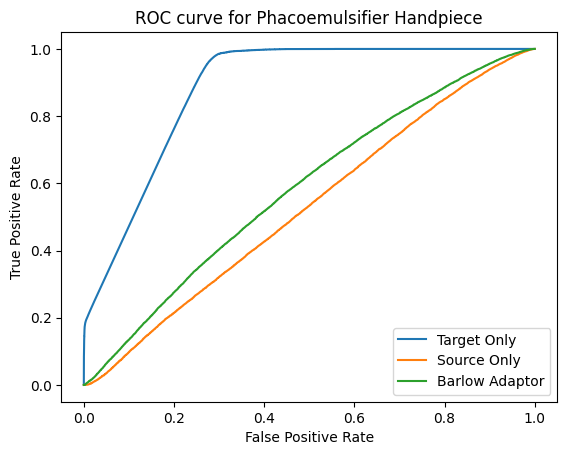

In [21]:
idx = 7
plt.plot(target_only_tpr[idx], target_only_fpr[idx])
plt.plot(source_only_tpr[idx], source_only_fpr[idx])
plt.plot(bt_tpr[idx], bt_fpr[idx])
plt.title("ROC curve for Phacoemulsifier Handpiece")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Target Only","Source Only","Barlow Adaptor"])

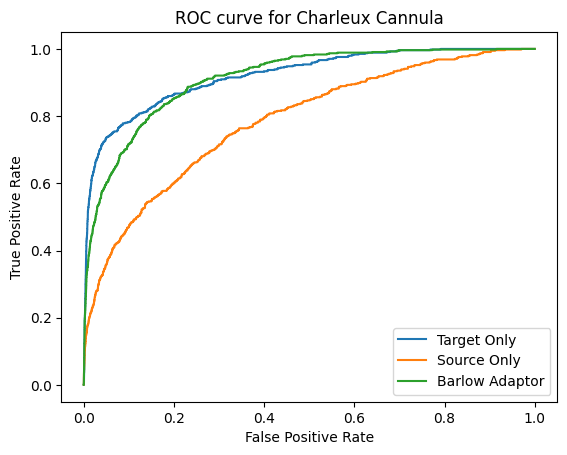

In [23]:
idx = 2
plt.plot(target_only_tpr[idx], target_only_fpr[idx])
plt.plot(source_only_tpr[idx], source_only_fpr[idx])
plt.plot(bt_tpr[idx], bt_fpr[idx])
plt.title("ROC curve for Charleux Cannula")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Target Only","Source Only","Barlow Adaptor"])

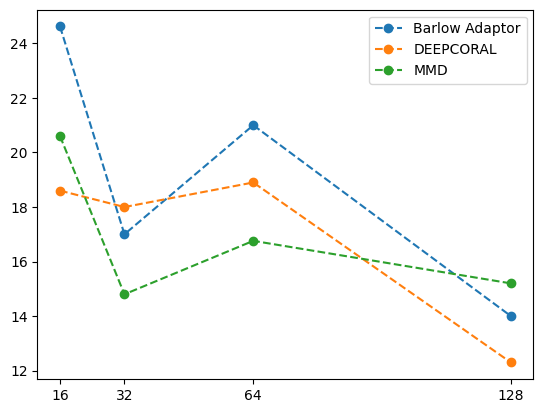

In [32]:
x = [16,32,64,128]
y_bt = [24.62, 17, 21, 14]
y_dc = [18.6, 18, 18.9, 12.3]
y_mmd = [20.6, 14.8, 16.76, 15.2]
plt.plot(x, y_bt, ls='--', marker='o')
plt.plot(x, y_dc, ls='--', marker='o')
plt.plot(x, y_mmd, ls='--', marker='o')
plt.xticks(x)
plt.xlabel("Batch Size")
plt.ylabel("Macro Accuracy")
plt.legend(["Barlow Adaptor", "DEEPCORAL", "MMD"])


In [ ]:
if mode==1:
    model_r50 = models.resnet50(pretrained=True)
    num_ftrs = model_r50.fc.in_features
    model_r50.fc = nn.Linear(num_ftrs, len(class_names))

    #only cataracts
    # model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/model_r50_trained_on_final_cataracts_only_ep25-50.pth"))
    #only d99
    model_r50.load_state_dict(torch.load("/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/mycode2/model_r50_trained_on_final_d99.pth"))

    model_r50 = model_r50.to(device)

    # test_model_mycode2(model_r50,d99_dataloaders['test'])
    test_model_mycode2(model_r50,cata_dataloaders['test'])

elif mode==2:
    #coral r50
    # model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss5_best.pth"
    #mmd r50
    # model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cataracts_tgt_d99_train_r50_bs16_bm1e-3_loss6_best.pth"
    #barlow+coral r50
    # model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss7_best.pth"
    model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-4_loss7.pth"
    model = load_model(model_path,class_names,use_vit=False)
    test(model, cata_dataloaders['test'], len(class_names))
    #barlow+mmd r50
    # model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss8_best.pth"

    # #coral timm
    # model_path1 = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss5_best.pth"
    # #mmd timm
    # model_path2 = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss6_best.pth"
    # #barlow+coral timm
    # model_path3 = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss7_best.pth"
    # #barlow+mmd timm
    # # model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_timm_bs16_bm1e-3_loss8.pth"
    # #only barlow
    # model_path4 = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_d99_tgt_cataracts_train_r50_bs16_bm1e-3_loss1_best.pth"

    # print("CORAL")
    # model = load_model(model_path1,class_names,use_vit=True)
    # test(model, cata_dataloaders['test'], len(class_names))

    # print("MMD")
    # model = load_model(model_path2,class_names,use_vit=True)
    # test(model, cata_dataloaders['test'], len(class_names))

    # print("BARLOW CORAL")
    # model = load_model(model_path3,class_names,use_vit=True)
    # test(model, cata_dataloaders['test'], len(class_names))

    # print("Only Barlow")
    # model = load_model(model_path4, class_names, use_vit=False)
    # test(model, cata_dataloaders['test'], len(class_names))

elif mode==3:
    model_path = "/home/ubuntu/Desktop/Domain_Adaptation_Project/repos/Transformer_dann_barlow/cataracts_saved_models_2/src_cata_tgt_d99_simpledann_best.pth"
    test_DANN(model_path, d99_dataloaders['test'], len(class_names))